# Acoustic wavefield separation - Volve data

**Author: M.Ravasi**

This notebook applies multi-component wavefield separation to the Volve data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

from scipy.signal import butter, lfilter, freqz
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from segyshot import SegyShot

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Data inspection

We can now download the file of interest following a similar approach to that explained in ``SeismicInversion-Volve`` notebook

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Raw_data/ST10010+NAV_MERGE/ST10010_1150780_40203.sgy --file ST10010_1150780_40203.sgy --sas-token "$YOURTOKEN"

Let's import input data from file

In [4]:
velfilepath = '../data/seismicinversion/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
filepath = '/project/volvepub/Seismic/ST10010/Raw_data/ST10010+NAV_MERGE/'

In [5]:
inputfiles = [filepath+'ST10010_1150780_40203.sgy', filepath+'ST10010_1151100_40204.sgy']
fs = [segyio.open(inputfile, ignore_geometry=True) for inputfile in inputfiles]
f = fs[0]
nfs = len(fs)

In [6]:
print(segyio.tools.wrap(f.text[0]))    

bytearray(b'C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION
TECHNOLOGY         C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY:
ST10010                C 3 SWATH:  11                             VESSELS:M/V
VIKLAND, M/V SANCO SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C1

## Data inspection

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


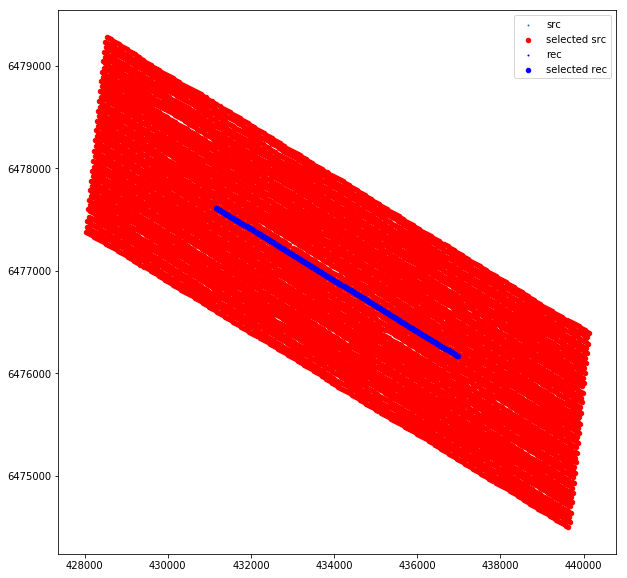

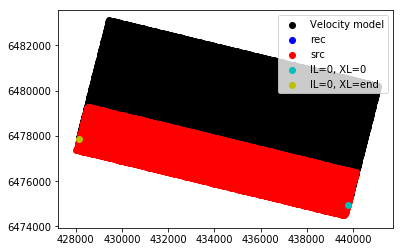

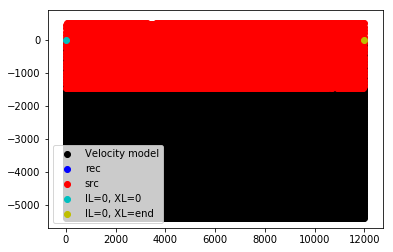

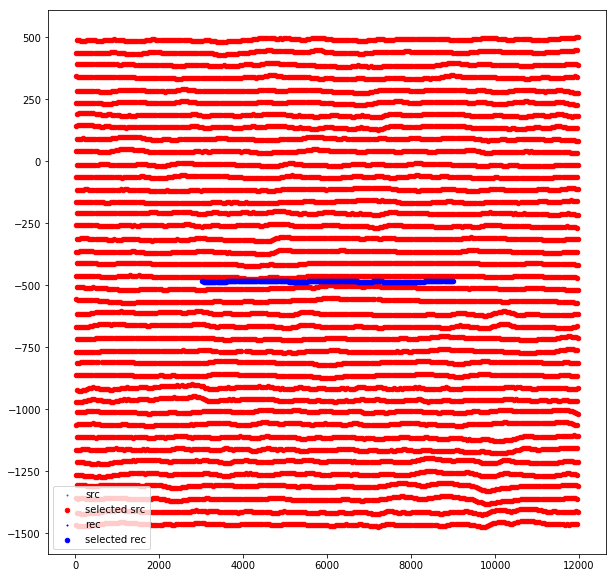

In [7]:
sg = SegyShot(inputfiles[0], components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()

sg.rotategeometry(velfile=velfilepath, plotflag=1)
sg.showgeometry(local=True)

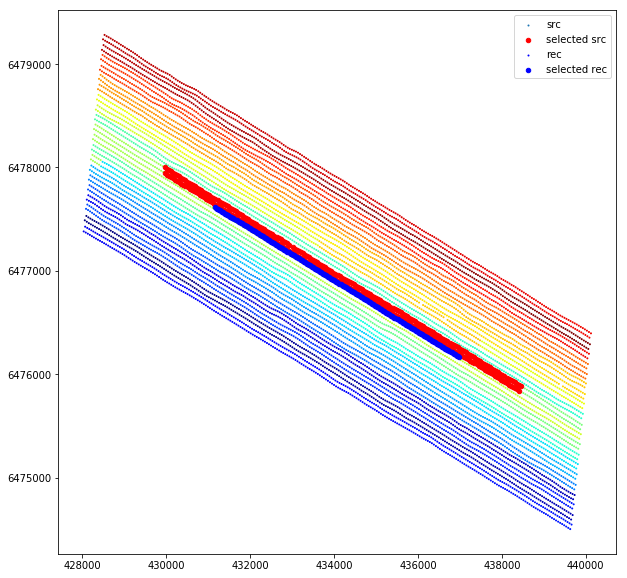

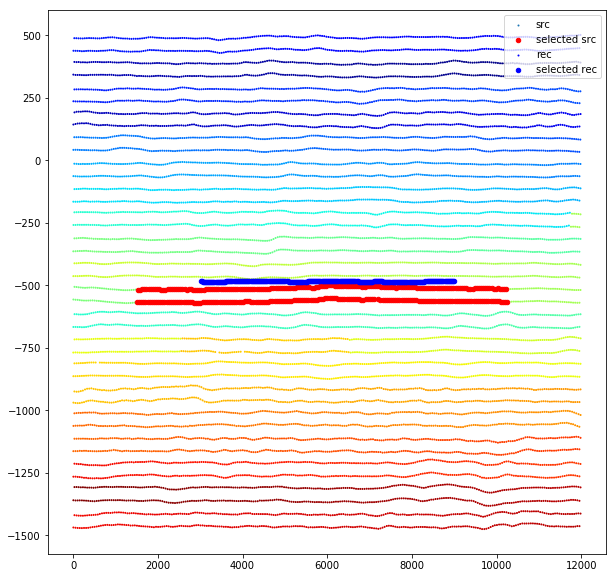

In [8]:
sg.selectsrcs(4850, 5200, plotflag=False)
sg.showgeometry()
sg.showgeometry(local=True)

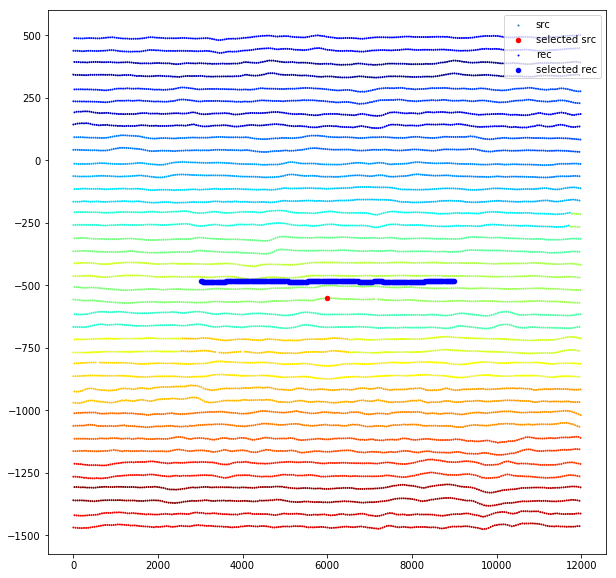

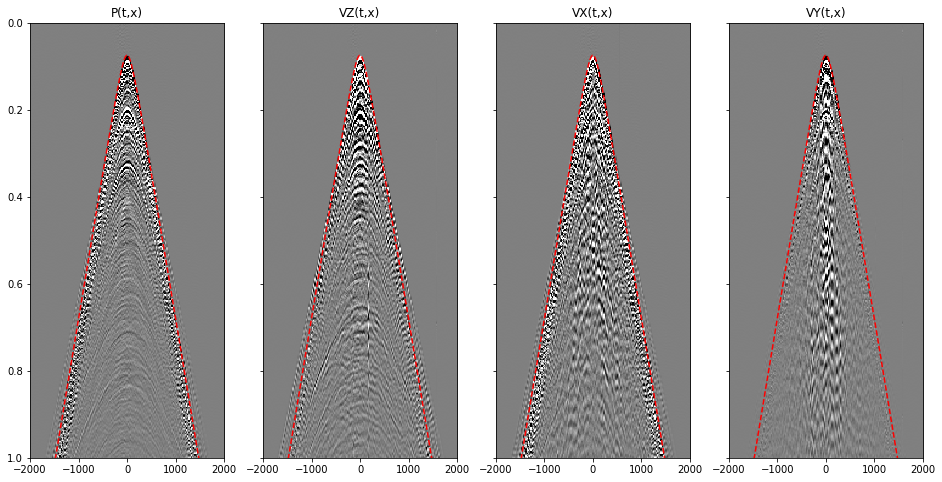

In [9]:
ishot = 5030
vwater = 1480.

sg.selectsrcs(ishot, ishot+1, plotflag=False)
sg.showgeometry(local=True)

offset = np.sqrt((sg.srcx[ishot] - sg.recx) ** 2 + (sg.srcy[ishot] - sg.recy) ** 2)
distance = np.sqrt((sg.srcz[ishot] - sg.recz) ** 2 + \
                   (sg.srcx[ishot] - sg.recx) ** 2 + \
                   (sg.srcy[ishot] - sg.recy) ** 2)
tdir = distance / vwater
offsetreg = np.linspace(-offset[0], offset[-1], sg.nrec)

shot = sg.get_shotgather(ishot)

# Apply derivative also to VZ to compensate for hydrophone derivative
#shot['VZ'] = np.hstack((np.diff(shot['VZ'], axis=1), np.zeros((sg.nrec, 1))))

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(shot['P'].T, cmap='gray', vmin=-5e6, vmax=5e6,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(shot['VZ'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(4, 0)
axs[2].imshow(shot['VX'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[2].plot(offsetreg, tdir, '--r')
axs[2].set_title('VX(t,x)')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
axs[3].imshow(shot['VY'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[3].plot(offsetreg, tdir, '--r')
axs[3].set_title('VY(t,x)')
axs[3].axis('tight')
axs[3].set_ylim(1., 0)
axs[3].set_xlim(-2000, 2000);

## Pre-processing

### Low-pass filter data

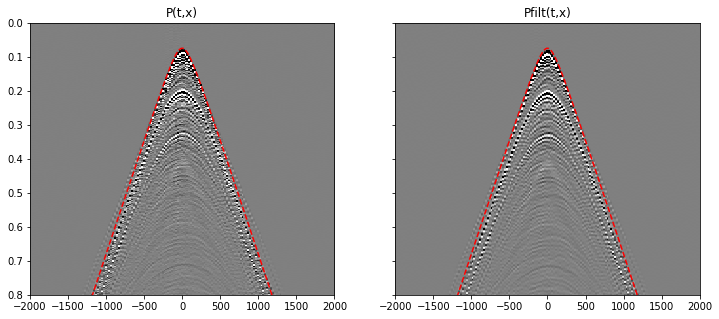

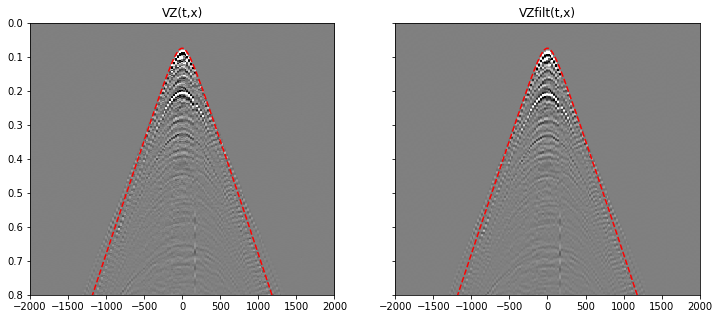

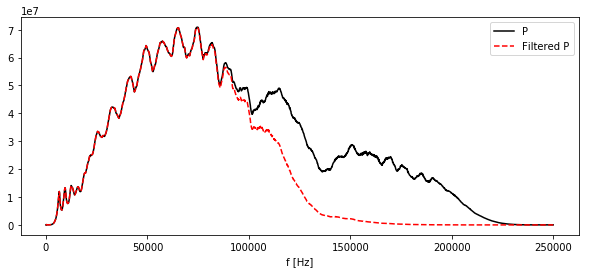

In [10]:
nfft = sg.nt
freq = np.fft.fftfreq(nfft, sg.dt / 1000.)
P = np.fft.fft(shot['P'], n=nfft, axis=-1)

pfilt = butter_lowpass_filter(shot['P'], 110., 1/sg.dt, 5)
Pfilt = np.fft.fft(pfilt, n=nfft, axis=-1)

vzfilt = butter_lowpass_filter(shot['VZ'], 110., 1/sg.dt, 5)
VZfilt = np.fft.fft(vzfilt, n=nfft, axis=-1)

# Display
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
axs[0].imshow(shot['P'].T, cmap='gray', vmin=-1e7, vmax=1e7,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('P(t,x)')
axs[0].axis('tight');
axs[1].imshow(pfilt.T, cmap='gray', vmin=-1e7, vmax=1e7,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('Pfilt(t,x)')
axs[1].axis('tight');
axs[1].set_ylim(.8, 0)
axs[1].set_xlim(-2000, 2000)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
axs[0].imshow(shot['VZ'].T, cmap='gray', vmin=-5e5, vmax=5e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('VZ(t,x)')
axs[0].axis('tight');
axs[1].imshow(vzfilt.T, cmap='gray', vmin=-5e5, vmax=5e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('VZfilt(t,x)')
axs[1].axis('tight');
axs[1].set_ylim(.8, 0)
axs[1].set_xlim(-2000, 2000)

plt.figure(figsize=(10, 4))
plt.plot(freq[:nfft//2], np.mean(np.abs(P), axis=0)[:nfft//2], 'k', label='P')
plt.plot(freq[:nfft//2], np.mean(np.abs(Pfilt), axis=0)[:nfft//2], '--r', label='Filtered P')
plt.xlabel('f [Hz]')
plt.legend();

### FK spectra

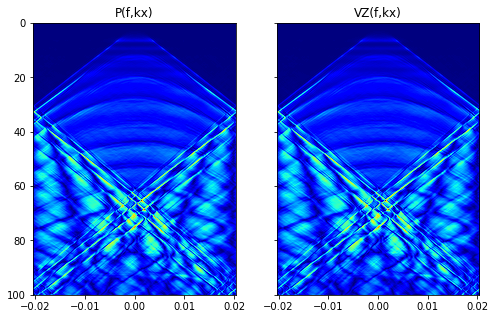

In [11]:
dr = np.mean(np.diff(sg.recx))

nffts = (sg.nrec, sg.nt)
FFTop = FFT2D(dims=[sg.nrec, sg.nt], 
              nffts=nffts, sampling=[dr, sg.dt])
P = FFTop * shot['P'].flatten()
P = P.reshape(nffts)
Pfilt = FFTop * pfilt.flatten()
Pfilt = Pfilt.reshape(nffts)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-FFTop.f1[nffts[0]//2-1], FFTop.f1[nffts[0]//2-1], FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[0].set_title('P(f,kx)')
axs[0].axis('tight');
axs[1].imshow(np.fft.fftshift(np.abs(Pfilt[:, :nfft//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-FFTop.f1[nffts[0]//2-1], FFTop.f1[nffts[0]//2-1], FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[1].axis('tight')
axs[0].set_ylim([100, 0])
axs[1].set_title('VZ(f,kx)');

## Analytical wavefield separation

In [12]:
def calibrated_wavefield_separation(sg, ishot, vwater = 1480., fmax=110., 
                                    twin = [0.01, 0.07], nfilt = 15,
                                    plotflag=False, vzsc=1, clip=1, tmax=1., offmax=None):
    # read geometry for selected shot
    src_x = sg.srcx_local[ishot]
    src_y = sg.srcy_local[ishot]
    src_z = sg.srcz[ishot]
    
    rec_x = sg.recx_local
    rec_y = sg.recy_local
    rec_z = sg.recz
    
    # compute offset
    offset_x = np.sqrt((src_x - rec_x) ** 2)
    offset = np.sqrt((src_x - rec_x) ** 2 + (src_y - rec_y) ** 2)
    distance = np.sqrt((src_z - rec_z) ** 2 + \
                       (src_x - rec_x) ** 2 + \
                       (src_y - rec_y) ** 2)
    tdir = distance / vwater
    offsetreg = np.linspace(-offset[0], offset[-1], sg.nrec)
    if offmax is None:
        offmin = offsetreg[0]
        offmax = offsetreg[-1]
    else:
        offmin = -offmax

    # read data
    shot = sg.get_shotgather(ishot)

    # filter data to remove high-freq noise
    pfilt = butter_lowpass_filter(shot['P'], fmax, 1/sg.dt, 5)
    Pfilt = np.fft.fft(pfilt, n=nfft, axis=-1)

    vzfilt = butter_lowpass_filter(shot['VZ'], fmax, 1/sg.dt, 5)
    VZfilt = np.fft.fft(vzfilt, n=nfft, axis=-1)
    
    # extract window around direct arrival
    itrace = np.argmin(offset)
    
    pwin = pfilt[itrace][int((tdir[itrace]-twin[0])/sg.dt):int((tdir[itrace]+twin[1])/sg.dt)]
    vzwin = vzfilt[itrace][int((tdir[itrace]-twin[0])/sg.dt):int((tdir[itrace]+twin[1])/sg.dt)]
    nwin = len(pwin)

    # perform calibration
    VZ = convmtx(vzwin, nfilt)[:nwin]
    h = np.linalg.lstsq(VZ, pwin)[0]
    vzwincalib = sp.signal.fftconvolve(vzwin, h)[:nwin]
    vzcalib = sp.signal.fftconvolve(vzfilt, h[np.newaxis, :], axes=-1)[:, :sg.nt]
    
    # perform separation
    pup = (pfilt - vzcalib) / 2
    pdown = (pfilt + vzcalib) / 2
    
    if plotflag:
        pmax = np.max(np.abs(pfilt))
        vzmax = np.max(np.abs(vzfilt))
        
        plt.figure(figsize=(2, 3))
        plt.plot(pwin, 'k')
        plt.plot(-vzwin * vzsc, 'r')
        
        plt.figure()
        plt.plot(h)
        plt.figure(figsize=(2, 3))
        plt.plot(pwin, 'k')
        plt.plot(vzwincalib, 'r')

        fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 7))
        axs[0].imshow(pfilt.T, cmap='gray', vmin=-clip*pmax, vmax=clip*pmax,
                      extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
        axs[0].set_title('P(t,x)')
        axs[0].axis('tight')
        axs[0].set_xlim(-offmax, offmax)
        axs[1].imshow(vzcalib.T, cmap='gray', vmin=-clip*pmax, vmax=clip*pmax,
                      extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
        axs[1].set_title('VZ(t,x)')
        axs[1].axis('tight')
        axs[1].set_xlim(-offmax, offmax)
        axs[1].set_ylim(tmax, 0)

        fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 7))
        axs[0].imshow(pfilt.T, cmap='gray', vmin=-clip*pmax, vmax=clip*pmax,
                      extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
        axs[0].set_title('P(t,x)')
        axs[0].set_xlim(-offmax, offmax)
        axs[0].axis('tight')
        axs[1].imshow(pup.T, cmap='gray', vmin=-clip*pmax, vmax=clip*pmax,
                      extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
        axs[1].set_title('P-(t,x)')
        axs[1].axis('tight')
        axs[1].set_xlim(-offmax, offmax)
        axs[2].imshow(pdown.T, cmap='gray', vmin=-clip*pmax, vmax=clip*pmax,
                      extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
        axs[2].set_title('P+(t,x)')
        axs[2].axis('tight')
        axs[2].set_xlim(-offmax, offmax)
        axs[2].set_ylim(tmax, 0)

    return pfilt, vzfilt, vzcalib, pup, pdown, offset_x, pfilt[itrace], pup[itrace], pdown[itrace], rec_x[itrace], rec_y[itrace]

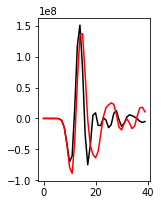

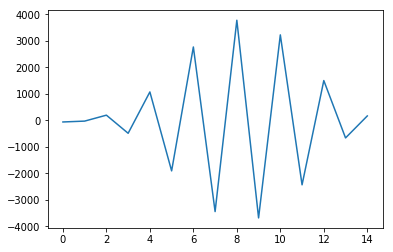

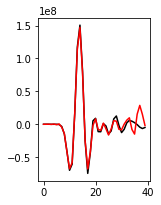

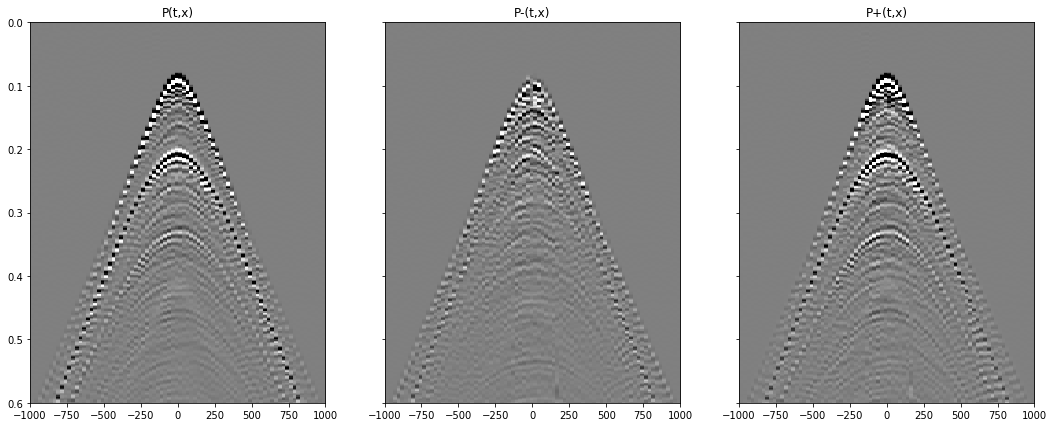

In [13]:
calibrated_wavefield_separation(sg, ishot, vwater = vwater, fmax=110., 
                                twin = [0.01, 0.07], nfilt = 15, 
                                plotflag=True, vzsc=60, clip=1e-1, tmax=0.6, offmax=1000);

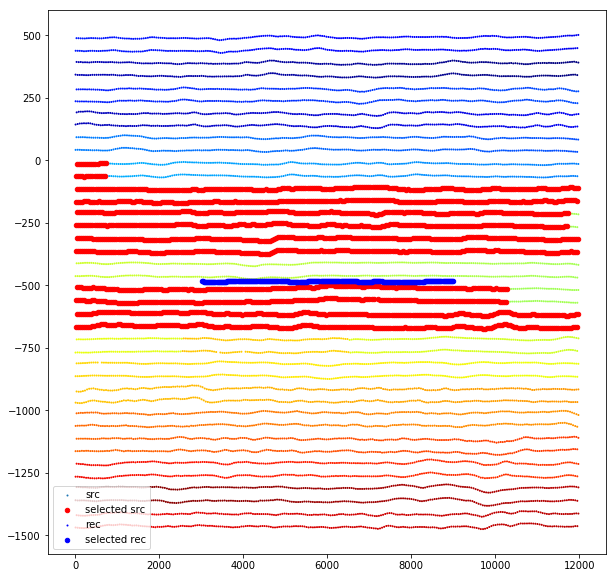

In [14]:
startshot=2850#4850
endshot=5200
nshots = endshot - startshot

sg.selectsrcs(startshot, endshot+1, plotflag=False)
sg.showgeometry(local=True)

p_zo = np.zeros((nshots, sg.nt))
pup_zo = np.zeros((nshots, sg.nt))
pdown_zo = np.zeros((nshots, sg.nt))
rec_x_zo = np.zeros(nshots)
rec_y_zo = np.zeros(nshots)

for i, shot in enumerate(range(startshot, endshot)):
    _, _, _, _, _, _, p_zo[i], pup_zo[i], pdown_zo[i], rec_x_zo[i], rec_y_zo[i] = \
        calibrated_wavefield_separation(sg, shot, vwater=vwater, fmax=110., 
                                        twin = [0.01, 0.07], nfilt = 15, 
                                        plotflag=False)

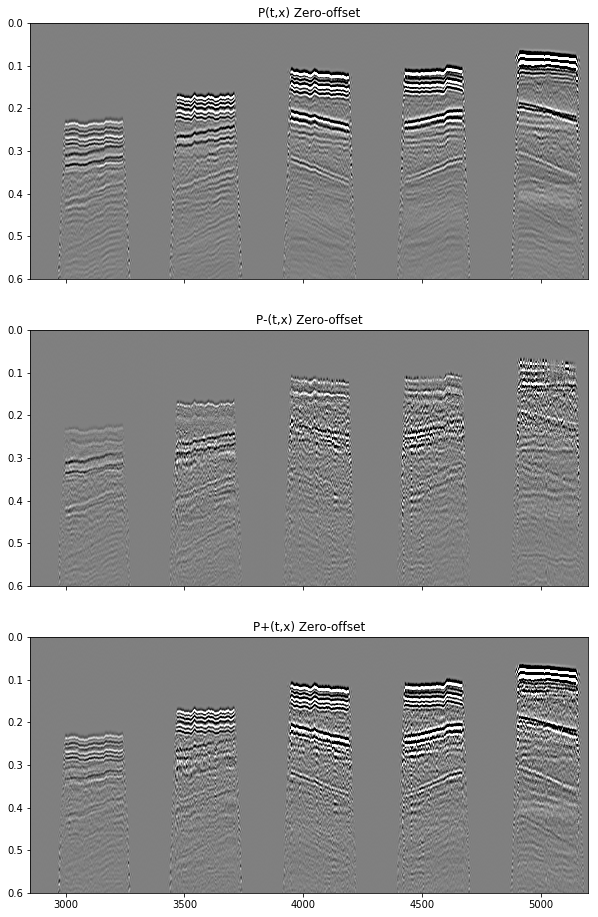

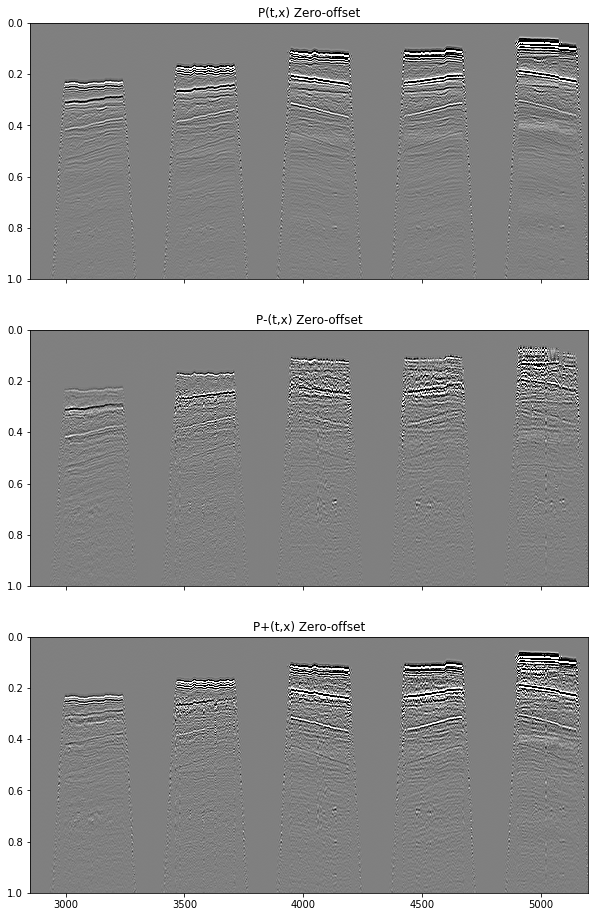

In [15]:
clip = 1e7

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 16))
axs[0].imshow(p_zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc',
             extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x) Zero-offset')
axs[0].axis('tight')
axs[1].imshow(pup_zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc',
             extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[1].set_title('P-(t,x) Zero-offset')
axs[1].axis('tight')
axs[2].imshow(pdown_zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc',
             extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[2].set_title('P+(t,x) Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(.6, 0.);

tgain = 1
#tgain = np.sqrt(t)[:, np.newaxis]
#tgain = t[:, np.newaxis]**2

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 16))
axs[0].imshow(tgain * p_zo[1::2].T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x) Zero-offset')
axs[0].axis('tight')
axs[1].imshow(tgain * pup_zo[1::2].T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[1].set_title('P-(t,x) Zero-offset')
axs[1].axis('tight')
axs[2].imshow(tgain * pdown_zo[1::2].T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[2].set_title('P+(t,x) Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(1., 0.);

## Wavefield separation by inversion

First we perform calibration as usual

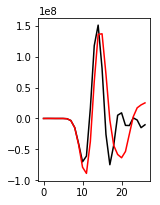

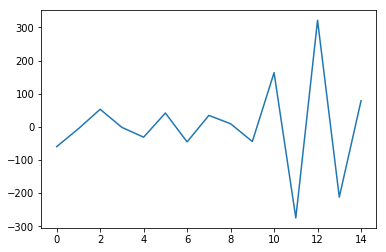

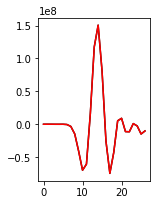

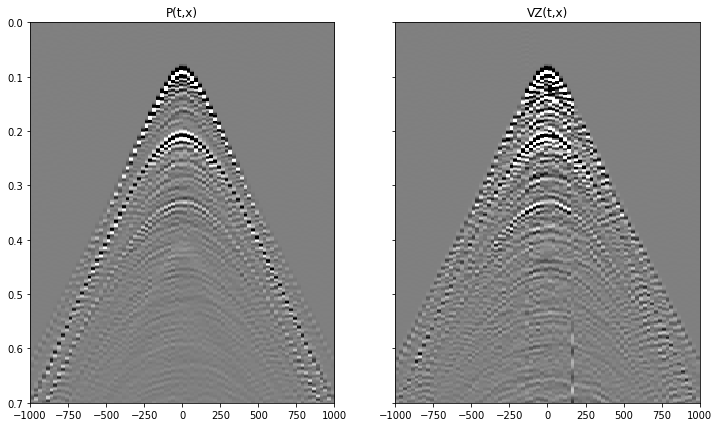

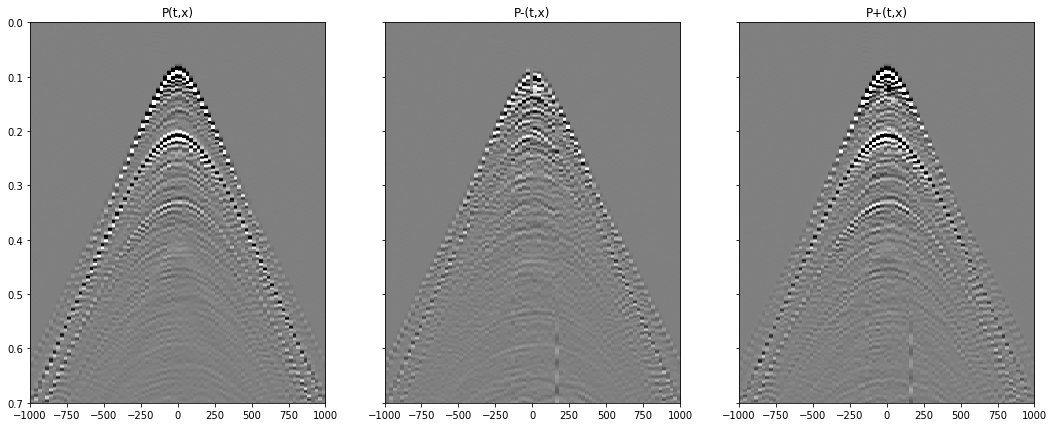

In [16]:
ishot = 5030
clip=1e-1
tmax=0.7

pfilt, vzfilt, vzcalib, _, _, offset = \
        calibrated_wavefield_separation(sg, ishot, vwater = vwater, fmax=110., 
                                        twin = [0.01, 0.045], nfilt = 15, 
                                        plotflag=True, vzsc=60, clip=clip, tmax=tmax, offmax=1000)[:6]

Let's start with performing a standard analytical separation in f-k domain

In [17]:
# Input parameters
critical = 1.1
ntaper = 21
vel_sep = 1500.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

# Extract time extent of interest
nt = sg.nt//2
t = sg.t[:nt]
pfilt = pfilt[:, :nt]
vzcalib = vzcalib[:, :nt] / (rho_sep*vel_sep) # as we have p and vz with same amplitudes

In [18]:
# Renormalize p and v
vzcalib /= pfilt.max()
pfilt /= pfilt.max()

In [19]:
nfft=2**12
FFTop = FFT2D(dims=[sg.nrec, nt], 
              nffts=[nfft, nfft], sampling=[dr, sg.dt])
dottest(FFTop, nfft*nfft, nt*sg.nrec, complexflag=2)

P = FFTop * pfilt[:, :nt].flatten()
VZ = FFTop * vzcalib[:, :nt].flatten()
P = P.reshape(nfft, nfft)
VZ = VZ.reshape(nfft, nfft)

In [20]:
#obliquity factor
[Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
k = F/vel_sep
Kz = np.sqrt((k**2-Kx**2).astype(np.complex))
Kz[np.isnan(Kz)] = 0

OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0

# cut off and taper
mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
OBL = OBL*mask
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=0)
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=1)

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1 = OBL1*mask
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=0)
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=1)

# scaled Vz
VZ_obl = OBL * VZ;
vz_obl = FFTop.H*VZ_obl.flatten()
vz_obl = np.real(vz_obl.reshape(sg.nrec, nt))

p = FFTop.H*P.flatten()
p = np.real(p.reshape(sg.nrec, nt))

# separation
pup = (pfilt - vz_obl)/2;
pdown = (pfilt + vz_obl)/2;

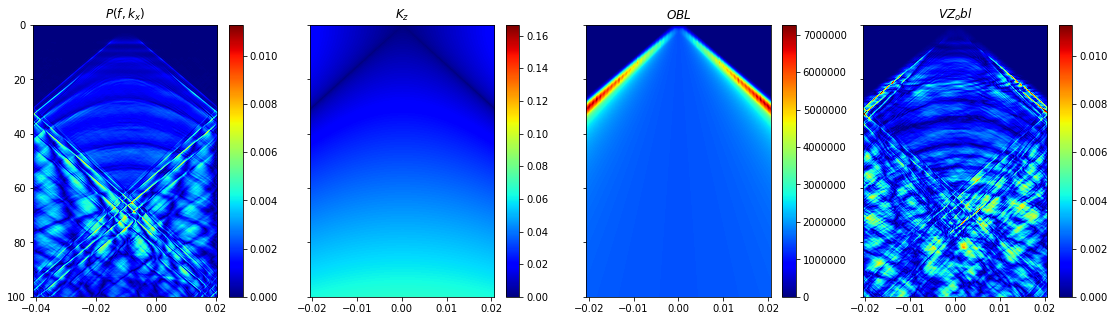

In [21]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
             extent = (-FFTop.f1[nfft//2-1]-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
             vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(Kz[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
             extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],))
axs[1].set_title(r'$K_z$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(np.fft.fftshift(np.abs(OBL[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent=(-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],))
axs[2].set_title(r'$OBL$')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2])
im=axs[3].imshow(np.fft.fftshift(np.abs(VZ_obl[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent=(-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[3].set_title(r'$VZ_obl$')
axs[3].axis('tight')
axs[3].set_ylim(100, 0)
plt.colorbar(im, ax=axs[3]);

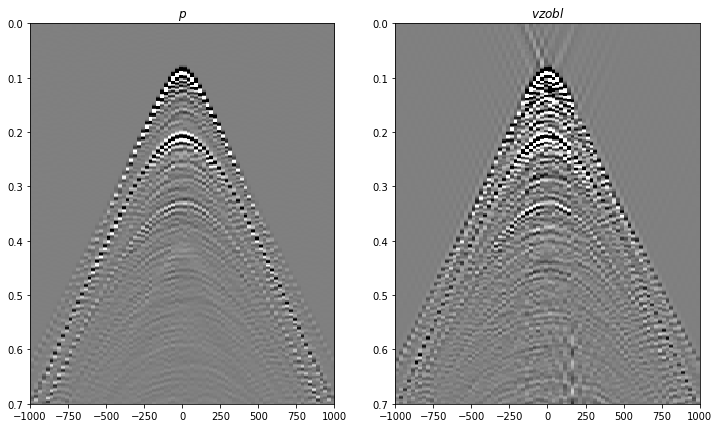

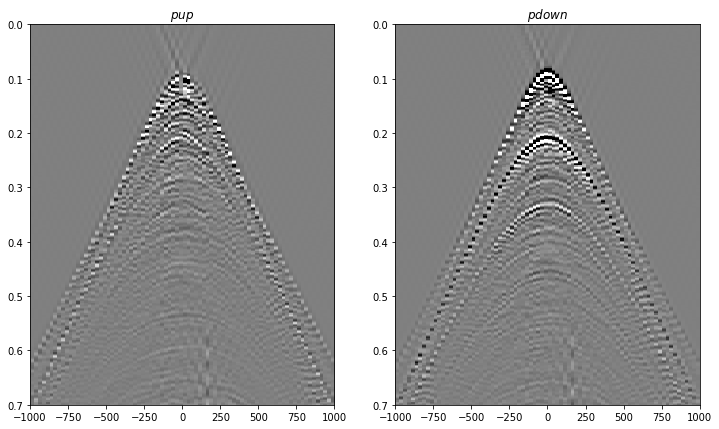

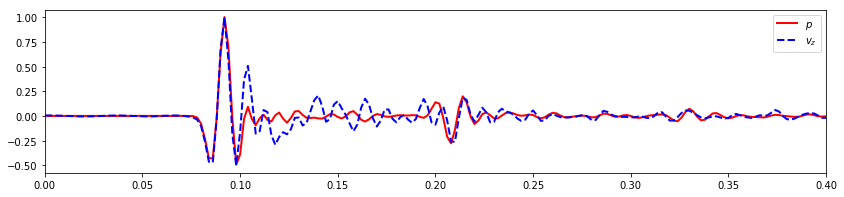

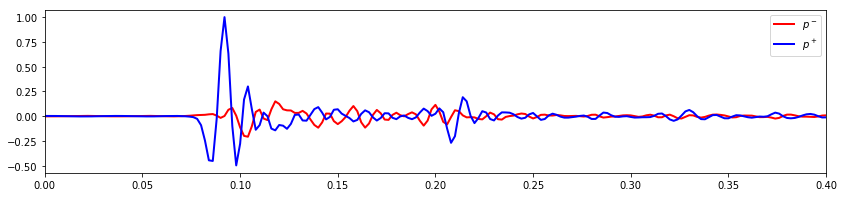

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12,7))
axs[0].imshow(pfilt.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(tmax, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')
axs[1].set_ylim(tmax, 0)
axs[1].set_xlim(-1000,1000)

fig, axs = plt.subplots(1, 2, figsize=(12,7))
axs[0].imshow(pup.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[0].set_ylim(tmax, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(pdown.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(tmax, 0)
axs[1].set_xlim(-1000,1000)

plt.figure(figsize=(14, 3))
plt.plot(t, pfilt[sg.nrec//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[sg.nrec//2], '--b', lw=2, label=r'$v_z$')
plt.xlim(0, 0.4)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup[sg.nrec//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown[sg.nrec//2], 'b', lw=2, label=r'$p^+$')
plt.xlim(0, 0.4)
plt.legend();

We now create the PyLops operators for the analytical case (they will become useful for the inversion case)

In [23]:
OBLop = Diagonal(OBL.flatten(), dtype='complex128')

Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
    Block([[Identity(nfft*nfft, dtype='complex128'), OBLop],
           [Identity(nfft*nfft, dtype='complex128'), -OBLop]])*\
           BlockDiag([FFTop, FFTop]))

d = np.concatenate((pfilt.flatten(), vzcalib.flatten()))
dud_lop = np.real(Sop * d)

d = d.reshape(2*sg.nrec, nt)
dud_lop = dud_lop.reshape(2*sg.nrec, nt)

pdown_lop, pup_lop = dud_lop[:sg.nrec], dud_lop[sg.nrec:]

print(np.linalg.norm(pdown - pdown_lop))
print(np.linalg.norm(pup - pup_lop))

7.688626087612217e-16
5.737825949362196e-16


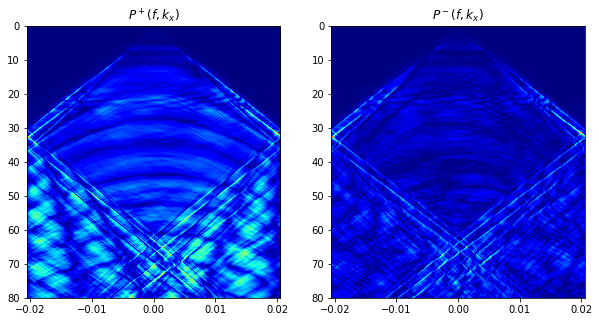

In [24]:
PUP_lop = (FFTop*pup_lop.flatten()).reshape(nfft, nfft)
PDOWN_lop = (FFTop*pdown_lop.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN_lop[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(80, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP_lop[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(80, 0);

Now we do separation by inversion

In [25]:
OBLop = Diagonal(OBL1.flatten(), dtype='complex128')

scaling = pfilt.max()/vzcalib.max()
S1op_scaled = (BlockDiag([FFTop.H, scaling*FFTop.H])*\
        Block([[Identity(nfft*nfft, dtype='complex128'), Identity(nfft*nfft, dtype='complex128')],
               [OBLop, -OBLop]])*\
        BlockDiag([FFTop, FFTop]))

d = np.concatenate((pfilt.flatten(), scaling*vzcalib.flatten()))

In [26]:
dud_inv, istop, itn, r1norm, r2norm = \
    lsqr(S1op_scaled, d.flatten(), damp=1e-10, iter_lim=20, show=2)[0:5]
dud_inv = np.real(dud_inv)
dud_inv = dud_inv.reshape(2*sg.nrec, nt)

pdown_inv, pup_inv= dud_inv[:sg.nrec], dud_inv[sg.nrec:]

print(np.linalg.norm(pdown - pdown_inv))
print(np.linalg.norm(pup - pup_inv))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has  1.2e+06 rows  and  1.2e+06 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.223e+00  8.223e+00    1.0e+00  1.7e-01
     1  1.40344e-08   9.173e-01  9.173e-01    1.1e-01  6.5e-01   1.4e+00  1.0e+00
     2 -3.80106e-06   5.910e-01  5.910e-01    7.2e-02  2.5e-01   1.8e+00  2.0e+00
     3 -8.32064e-06   5.039e-01  5.039e-01    6.1e-02  1.7e-01   2.1e+00  3.4e+00
     4 -1.04581e-05   4.556e-01  4.556e-01    5.5e-02  1.3e-01   2.3e+00  5.0e+00
     5 -9.45740e-06   4.190e-01  4.190e-01    5.1e-02  1.1e-01   2.5e+00  7.1e+00
     6 -5.78053e-06   3.939e-01  3.939e-01    4.8e-02  8.2e-02   2.7e+00  9.2e+00
     7 -2.78858e-06   3.780e-01  3.780e-01    4.6e-02  6.6e-02   2.9e+00  1.1e+01
     8 -1.81167e-06   3.664e

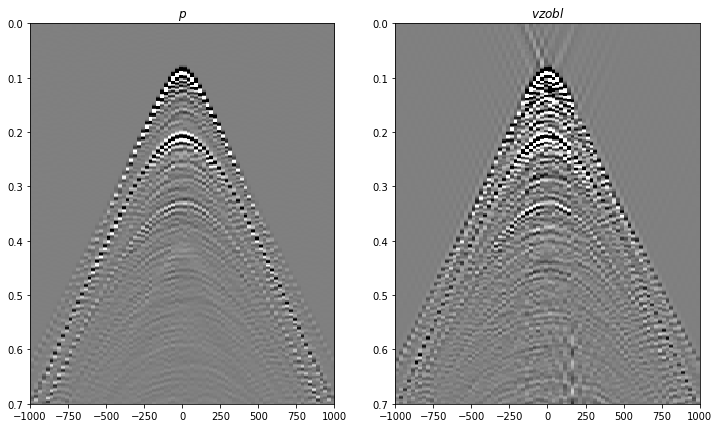

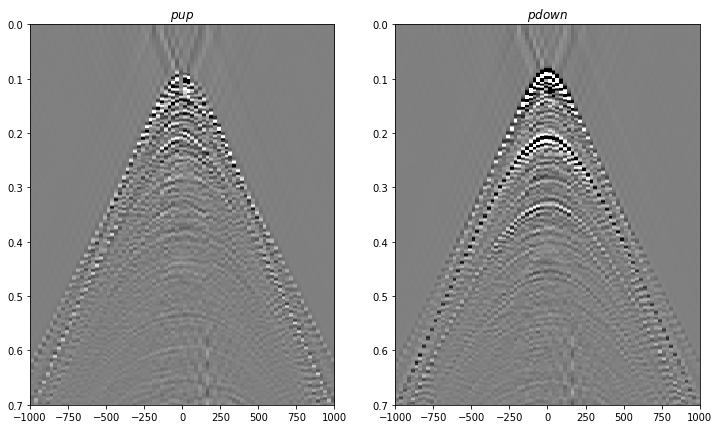

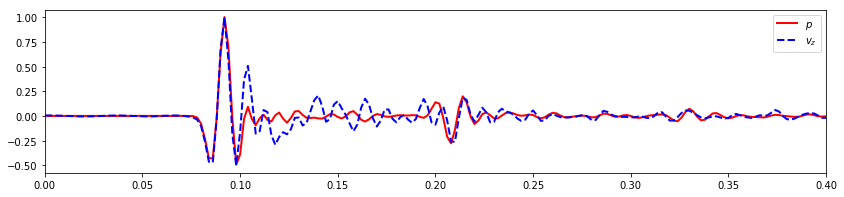

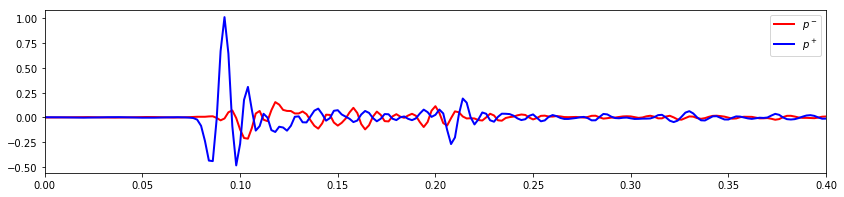

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12,7))
axs[0].imshow(pfilt.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(tmax, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')
axs[1].set_ylim(tmax, 0)
axs[1].set_xlim(-1000,1000)

fig, axs = plt.subplots(1, 2, figsize=(12,7))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[0].set_ylim(tmax, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(tmax, 0)
axs[1].set_xlim(-1000,1000)

plt.figure(figsize=(14, 3))
plt.plot(t, pfilt[sg.nrec//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[sg.nrec//2], '--b', lw=2, label=r'$v_z$')
plt.xlim(0, 0.4)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[sg.nrec//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[sg.nrec//2], 'b', lw=2, label=r'$p^+$')
plt.xlim(0, 0.4)
plt.legend();

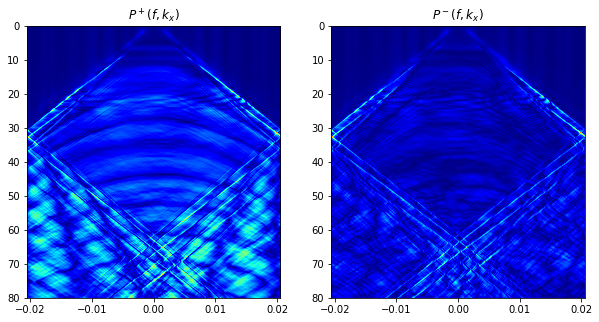

In [28]:
PUP_inv = (FFTop*pup_inv.flatten()).reshape(nfft, nfft)
PDOWN_inv = (FFTop*pdown_inv.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN_inv[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(80, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP_inv[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(80, 0);

## Wavefield separation by inversion with data regularization

In [29]:
# Create offset axis 
offset_shifted = offset.copy()

ioffset_center = np.argmin(offset_shifted)
offset_shifted[:ioffset_center] *=-1
offset_shifted -= offset_shifted[0]

# Create regular offset axis 
nrec_reg = 601
offset_reg = np.linspace(0, offset_shifted[-1]+10., nrec_reg)
doffset_reg = offset_reg[1]
print(doffset_reg)

# Create interpolation operator
Rop = Interp(nrec_reg*nt, offset_shifted/doffset_reg, 
             dims=(nrec_reg, nt), kind='nearest',
             dir=0, dtype='float64')[0]
Rop = BlockDiag([Rop, Rop])

# FFT operator in new space axis
FFT1op = FFT2D(dims=[nrec_reg, nt], 
               nffts=[nfft, nfft], sampling=[doffset_reg, sg.dt])
dottest(FFT1op, nfft*nfft, nt*nrec_reg, complexflag=2);

9.989331598460744


True

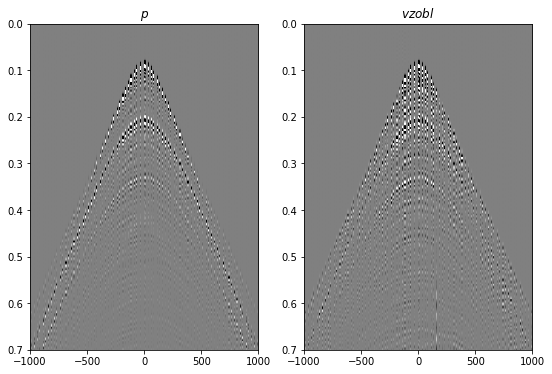

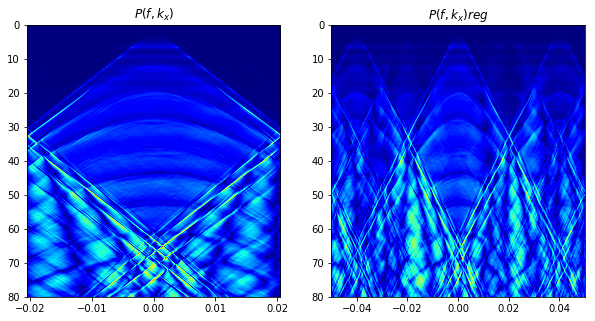

In [30]:
scaling = pfilt.max()/vzcalib.max()
d = np.concatenate((pfilt.flatten(), vzcalib.flatten()))

d_subsampled_adj = Rop.H * d.ravel()
d_subsampled_adj = d_subsampled_adj.reshape(2*nrec_reg, nt)
p_subsampled_adj, vz_subsampled_adj= d_subsampled_adj[:nrec_reg], d_subsampled_adj[nrec_reg:]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p_subsampled_adj.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(tmax, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(vz_subsampled_adj.T, cmap='gray', vmin=-clip*np.abs(vzcalib).max(), vmax=clip*np.abs(vzcalib).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')
axs[1].set_ylim(tmax, 0)
axs[1].set_xlim(-1000,1000);


P_adj = FFT1op * p_subsampled_adj[:, :nt].flatten()
P_adj = P_adj.reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(80, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(P_adj[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFT1op.f1[nfft//2-1], FFT1op.f1[nfft//2-1], FFT1op.f2[nfft//2-1], FFT1op.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$P(f, k_x) reg$')
axs[1].axis('tight');
axs[1].set_ylim(80, 0);

In [31]:
# Sliding window radon with overlap
nwin=51
nwins=16
nover=15
npx=101
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
dimsd = (nrec_reg, nt)
dims = (nwins*npx, nt)

Op = Radon2D(t, np.linspace(-doffset_reg*nwin//2, doffset_reg*nwin//2, nwin), px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine', design=True)
dottest(Slidop, np.prod(dimsd), np.prod(dims))

 1414 1515], end:[ 101  202  303  404  505  606  707  808  909 1010 1111 1212 1313 1414
 1515 1616]


True

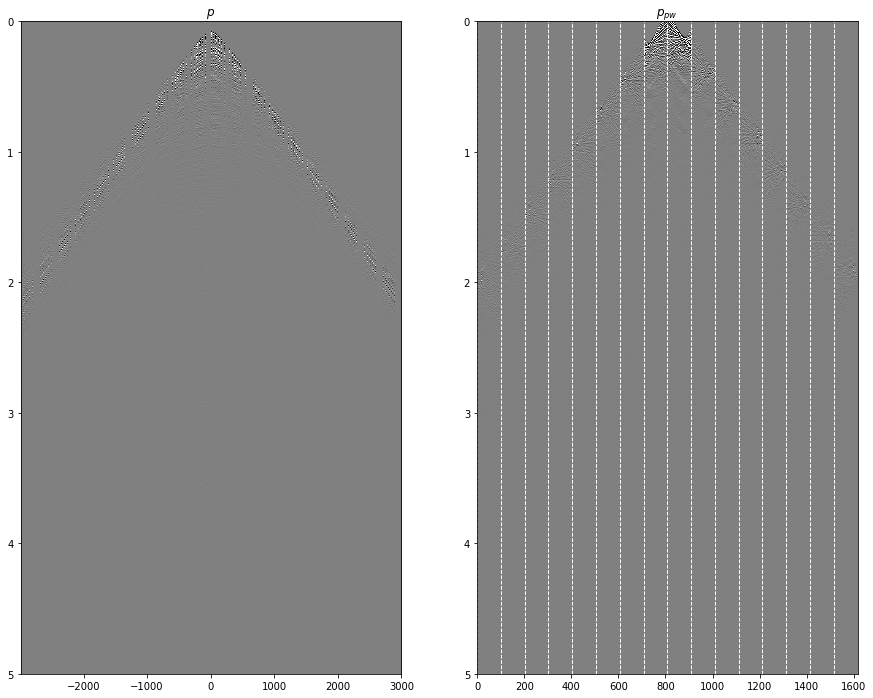

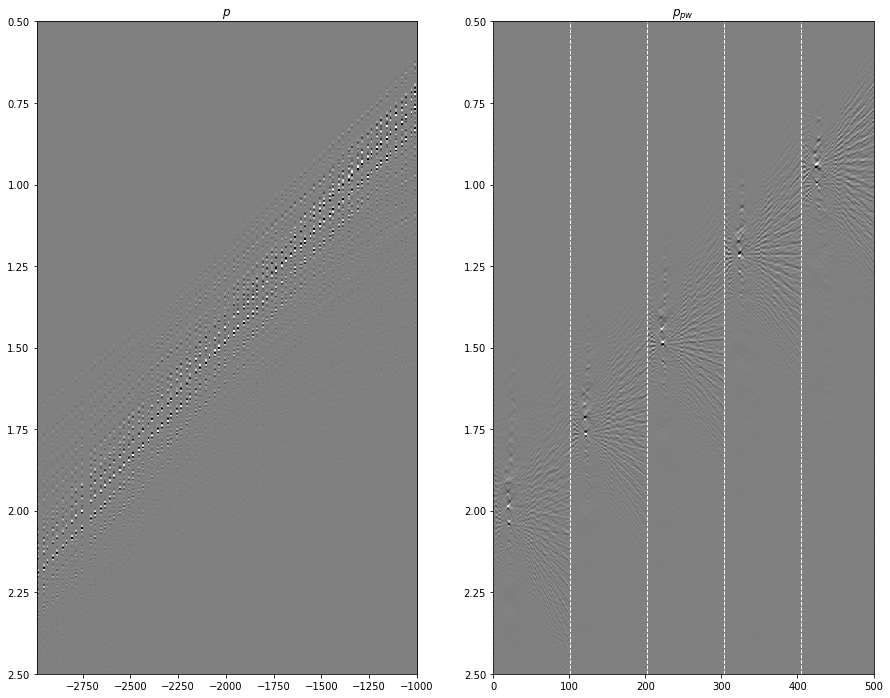

In [48]:
p_pw = Slidop.H * p_subsampled_adj.ravel()
p_pw = p_pw.reshape(npx*nwins, nt)

fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(p_subsampled_adj.T, cmap='gray',  vmin=-clip*np.abs(p_subsampled_adj).max(), 
              vmax=clip*np.abs(p_subsampled_adj).max(), extent=(-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(5, 0)
axs[1].imshow(p_pw.T, cmap='gray', vmin=-0.1*np.abs(p_pw).max(), 
              vmax=0.1*np.abs(p_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].set_title(r'$p_{pw}$')
axs[1].axis('tight')
axs[1].set_ylim(5, 0)

fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(p_subsampled_adj.T, cmap='gray',  vmin=-clip*np.abs(p_subsampled_adj).max(), 
              vmax=clip*np.abs(p_subsampled_adj).max(), extent=(-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_xlim(-offset[0], -1000);
axs[0].set_ylim(2.5, 0.5)
axs[1].imshow(p_pw.T, cmap='gray', vmin=-0.1*np.abs(p_pw).max(), 
              vmax=0.1*np.abs(p_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].set_title(r'$p_{pw}$')
axs[1].axis('tight')
axs[1].set_xlim(0, 500);
axs[1].set_ylim(2.5, 0.5);

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 1200000 rows and 8080000 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 2.914496e-04	thresh = 1.457248e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   3.156e+01   3.165e+01   2.564e-02
     2   0.00000e+00   2.948e+01   2.967e+01   2.457e-02
     3   0.00000e+00   2.705e+01   2.734e+01   3.020e-02
     4   0.00000e+00   2.440e+01   2.481e+01   3.491e-02
     5   0.00000e+00   2.165e+01   2.220e+01   3.874e-02
     6   0.00000e+00   1.890e+01   1.961e+01   4.172e-02
     7   0.00000e+00   1.627e+01   1.713e+01   4.386e-02
     8   0.00000e+00   1.380e+01   1.482e+01   4.523e-02
     9   0.00000e+00   1.156e+01   1.274e+01   4.587e-02
    10   0.00000e+00   9.564e+00   1.090e+01   4.585e-02
    11   0.00000e+00   7.830e+00   9.326e+00   4.525e-02
    21   0.000

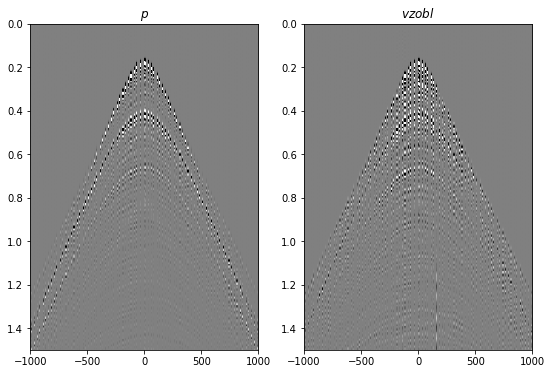

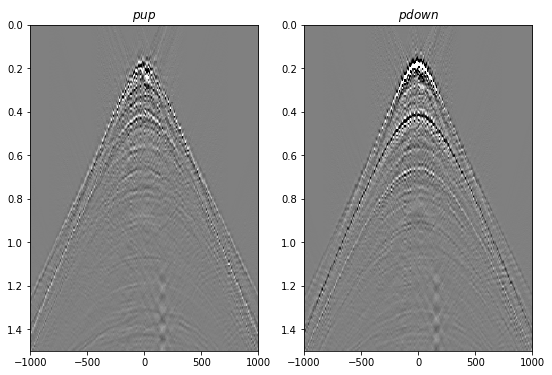

In [33]:
pup_inv, pdown_inv = WavefieldDecomposition(pfilt, vzcalib, nt, nrec_reg, sg.dt, doffset_reg,
                                            rho_sep, vel_sep, 
                                            nffts=(nfft, nfft), scaling= scaling,
                                            sptransf=Slidop, restriction=Rop,
                                            dtype='complex128', solver=FISTA,
                                            **dict(niter=100, eigsiter=10, eigstol=1e-3,
                                                   threshkind='soft', eps=1e-2, #eps=3e-2, 
                                                   #threshkind='half-percentile', perc=5, 
                                                   show=True))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p_subsampled_adj.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(vz_subsampled_adj.T, cmap='gray', vmin=-clip*np.abs(vzcalib).max(), vmax=clip*np.abs(vzcalib).max(),
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[1].set_xlim(-1000,1000);

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[0].set_xlim(-1000,1000)
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[1].set_xlim(-1000,1000);

(-2000, 1000)

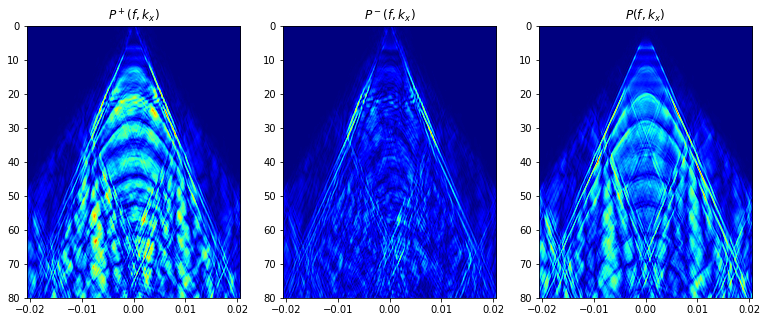

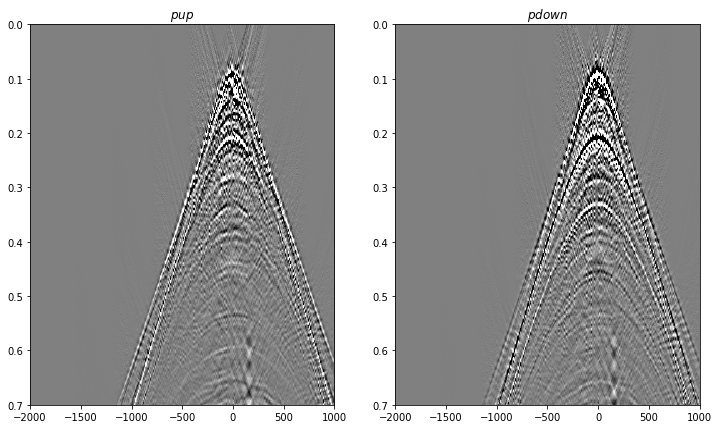

In [51]:
PUP_inv = (FFT1op*pup_inv.flatten()).reshape(nfft, nfft)
PDOWN_inv = (FFT1op*pdown_inv.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 3, figsize=(13, 5))
axs[0].imshow(np.fft.fftshift(np.abs(PDOWN_inv[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(80, 0)
axs[1].imshow(np.fft.fftshift(np.abs(PUP_inv[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(80, 0)
axs[2].imshow(np.fft.fftshift(np.abs((PUP_inv+PDOWN_inv)[:, :nfft//2-1]),axes=0).T, cmap='jet', 
              interpolation='sinc', 
              extent = (-FFTop.f1[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0],),
              vmin=0, vmax=np.abs(P).max())
axs[2].set_title(r'$P(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(80, 0)

fig, axs = plt.subplots(1, 2, figsize=(12,7))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[0].set_ylim(tmax, 0)
axs[0].set_xlim(-2000,1000)
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(tmax, 0)
axs[1].set_xlim(-2000,1000);

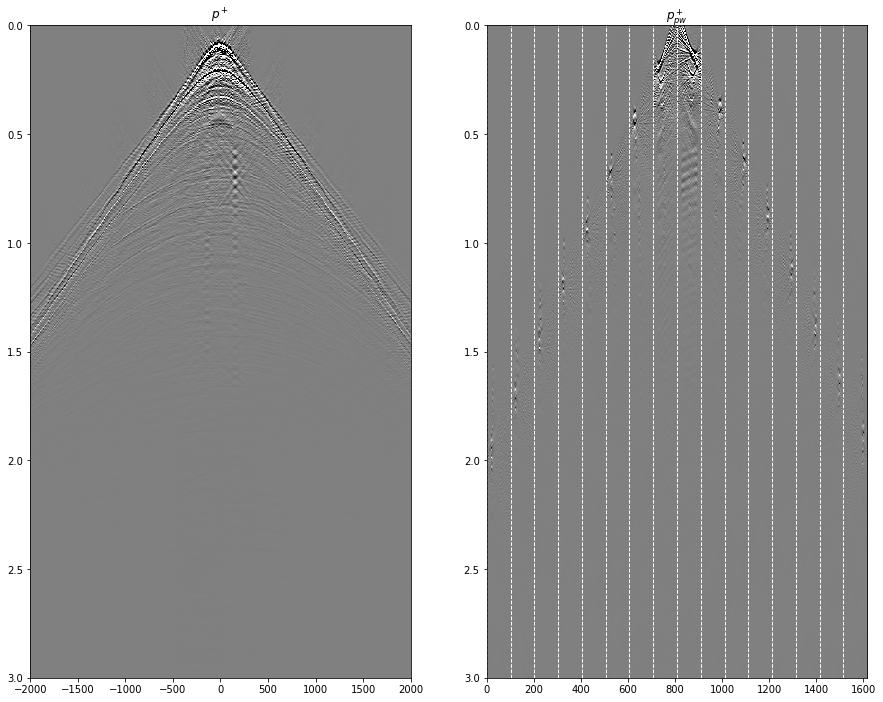

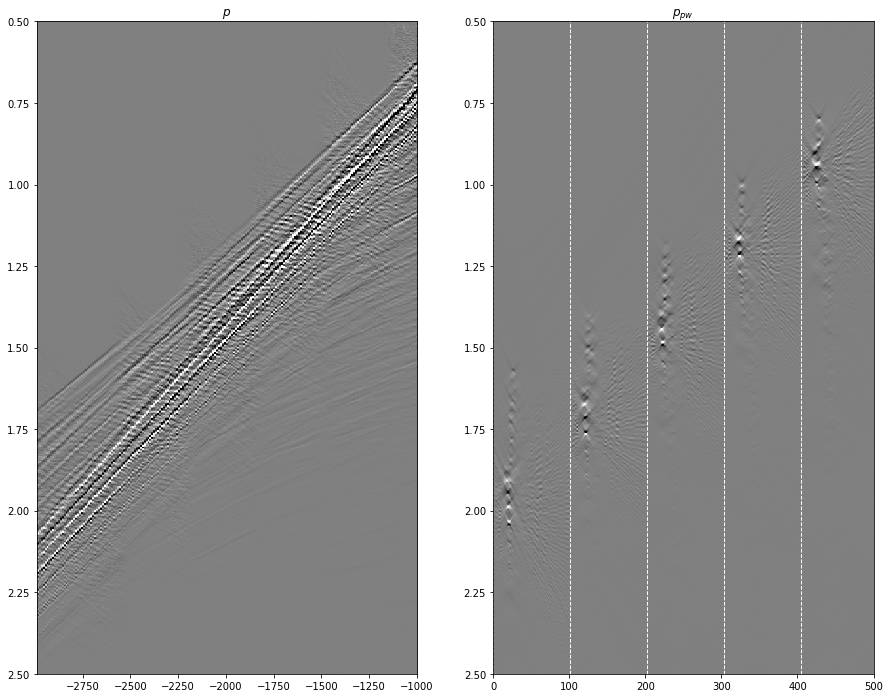

In [44]:
pdown_inv_pw = Slidop.H * pdown_inv.ravel()
pdown_inv_pw = pdown_inv_pw.reshape(npx*nwins, nt)

clip=3e-2
fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(pdown_inv.T, cmap='gray',  vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent=(-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p^+$')
axs[0].axis('tight')
axs[0].set_xlim(-2000, 2000);
axs[0].set_ylim(3, 0)
axs[1].imshow(pdown_inv_pw.T, cmap='gray', vmin=-0.1*np.abs(pdown_inv_pw).max(), 
              vmax=0.1*np.abs(pdown_inv_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].set_title(r'$p^+_{pw}$')
axs[1].axis('tight')
axs[1].set_ylim(3, 0);

fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(pdown_inv.T, cmap='gray',  vmin=-0.01*np.abs(p_subsampled_adj).max(), 
              vmax=0.01*np.abs(p_subsampled_adj).max(), extent=(-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_xlim(-offset[0], -1000);
axs[0].set_ylim(2.5, 0.5)
axs[1].imshow(pdown_inv_pw.T, cmap='gray', vmin=-0.1*np.abs(p_pw).max(), 
              vmax=0.1*np.abs(p_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].set_title(r'$p_{pw}$')
axs[1].axis('tight')
axs[1].set_xlim(0, 500)
axs[1].set_ylim(2.5, 0.5);

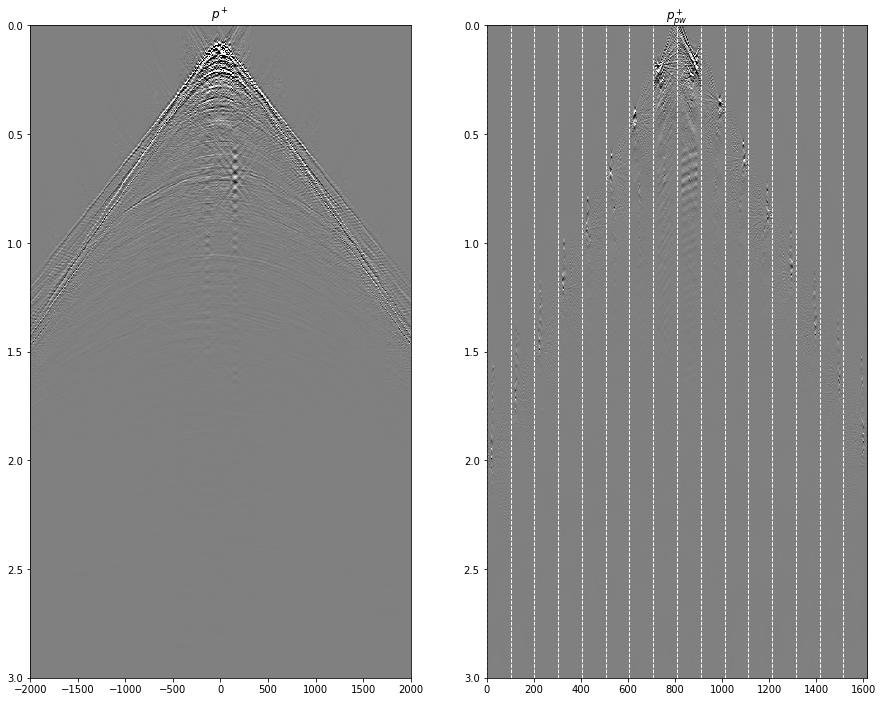

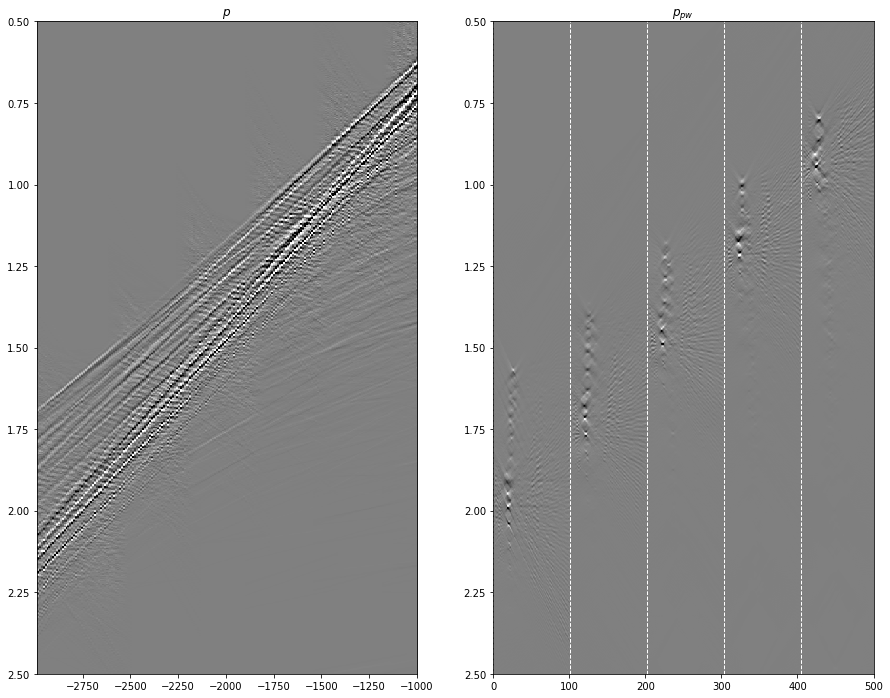

In [45]:
pup_inv_pw = Slidop.H * pup_inv.ravel()
pup_inv_pw = pup_inv_pw.reshape(npx*nwins, nt)

fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(pup_inv.T, cmap='gray',  vmin=-clip*np.abs(pfilt).max(), vmax=clip*np.abs(pfilt).max(),
              extent=(-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p^+$')
axs[0].axis('tight')
axs[0].set_xlim(-2000, 2000);
axs[0].set_ylim(3, 0)
axs[1].imshow(pup_inv_pw.T, cmap='gray', vmin=-0.1*np.abs(pdown_inv_pw).max(), 
              vmax=0.1*np.abs(pdown_inv_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].set_title(r'$p^+_{pw}$')
axs[1].axis('tight')
axs[1].set_ylim(3, 0);

fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(pup_inv.T, cmap='gray',  vmin=-0.01*np.abs(p_subsampled_adj).max(), 
              vmax=0.01*np.abs(p_subsampled_adj).max(), extent=(-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_xlim(-offset[0], -1000);
axs[0].set_ylim(2.5, 0.5)
axs[1].imshow(pup_inv_pw.T, cmap='gray', vmin=-0.1*np.abs(p_pw).max(), 
              vmax=0.1*np.abs(p_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].set_title(r'$p_{pw}$')
axs[1].axis('tight')
axs[1].set_xlim(0, 500);
axs[1].set_ylim(2.5, 0.5);

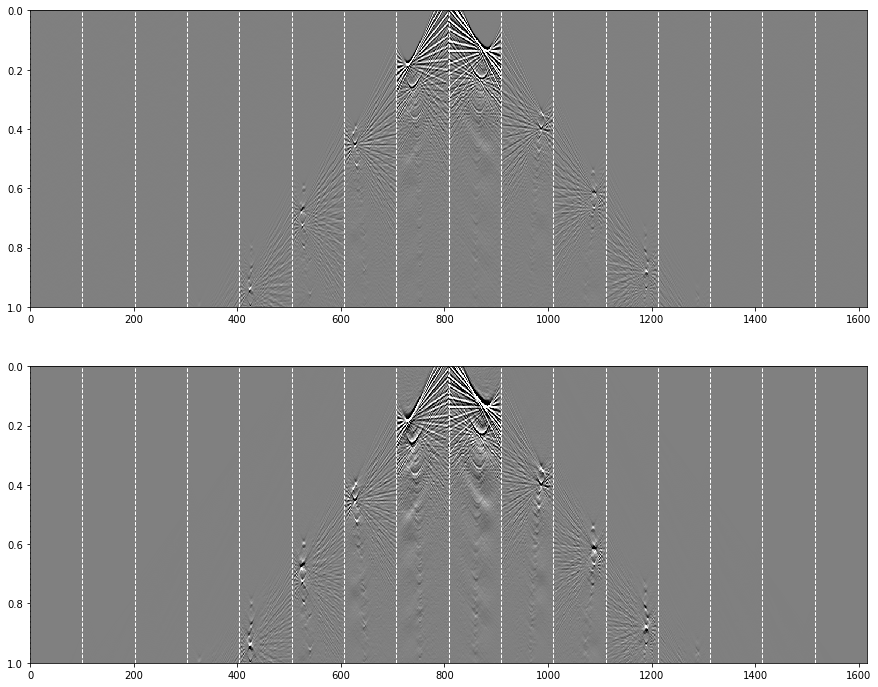

In [37]:
prec_pw = Slidop.H * (pup_inv + pdown_inv).ravel()
prec_pw = prec_pw.reshape(npx*nwins, nt)

fig, axs = plt.subplots(2, 1, figsize=(15, 12))
axs[0].imshow(p_pw.T, cmap='gray', vmin=-0.1*np.abs(prec_pw).max(), 
              vmax=0.1*np.abs(prec_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[0].axvline(i, color='w', lw=1, ls='--')
axs[0].axis('tight')
axs[0].set_ylim(1, 0)

axs[1].imshow(prec_pw.T, cmap='gray', vmin=-0.1*np.abs(prec_pw).max(), 
              vmax=0.1*np.abs(prec_pw).max(), extent=(0, nwins*npx, t[-1], t[0]))
for i in range(0, nwins*npx, npx):
    axs[1].axvline(i, color='w', lw=1, ls='--')
axs[1].axis('tight')
axs[1].set_ylim(1, 0);

#### Next steps

- Start with analytical separation below $f_aliasing$ and use that as starting guess for inversion of full bandwidth
- Use estimated slopes in low-frequency estimates to penalize slant stack for those slopes-intercept pairs that do not belong to the expected slopes in the data
- Repeat in 3d (need to see how many cables are laid at the same time = same source)